In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize 
# from simpeg import dask
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation

In [2]:
Solver = get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

# load data 

In [3]:
directory = "./synthetic-data-10m"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.split(".")[-1]=="txt"]

print(files)

['rx_times.txt', 'background.txt', 'target_30.txt', 'target_45.txt', 'target_0.txt', 'rx_locs.txt', 'target_15.txt']


In [4]:
files

['rx_times.txt',
 'background.txt',
 'target_30.txt',
 'target_45.txt',
 'target_0.txt',
 'rx_locs.txt',
 'target_15.txt']

In [5]:
files.remove("rx_locs.txt")
rx_locs = np.loadtxt(f"{directory}/rx_locs.txt")

files.remove("rx_times.txt")
rx_times = np.loadtxt(f"{directory}/rx_times.txt")

In [6]:
dobs_dict = {}

for f in files: 
    key = f.split(".")[0]
    dobs_dict[key] = np.loadtxt(f"{directory}/{f}")

# create survey

In [7]:
data_dict = {}

for key, value in dobs_dict.items(): 
    source_list = []
    for i in range(rx_locs.shape[0]): 
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)
    
    full_survey = tdem.Survey(source_list)

    data_dict[key] = Data(survey=full_survey, dobs=value)

In [8]:
ind = 25
rx_locs[ind, :]

array([-255.,    0.,   30.])

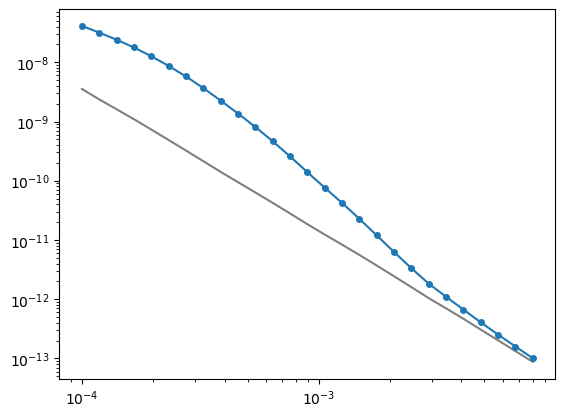

In [9]:
key = "target_0"
ind = 25
src_background = data_dict["background"].survey.source_list[ind]
src = data_dict[key].survey.source_list[ind]

plt.loglog(rx_times, -data_dict["background"][src_background, src_background.receiver_list[0]], "k", alpha=0.5)
plt.loglog(rx_times, -data_dict[key][src, src.receiver_list[0]], "C0-o", ms=4)

In [10]:
mesh = discretize.load_mesh(f"{directory}/treemesh.json")

/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/utils/io_utils.py:39: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  data = cls(**jsondict)


In [11]:
active_cells_map = maps.InjectActiveCells(mesh, mesh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))

In [12]:
# full_source_list = []

# for i in range(rx_locs.shape[0]): 
#     rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
#     src = tdem.sources.CircularLoop(
#         receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
#         waveform=tdem.sources.StepOffWaveform()
#     )
#     full_source_list.append(src)

# full_survey = tdem.Survey(full_source_list)

In [13]:
n_times_invert = 20



In [14]:
data_dict_invert = {}

for key, value in dobs_dict.items(): 

    source_list = []

    for i in range(rx_locs.shape[0]): 
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10, 
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)
    
    survey = tdem.Survey(source_list)
    
    data_dict_invert[key] = Data(
        survey=survey, 
        dobs=(value.reshape(rx_locs.shape[0], len(rx_times))[:, :n_times_invert]).flatten(), 
        relative_error=0.1, 
        noise_floor=1e-11
    )

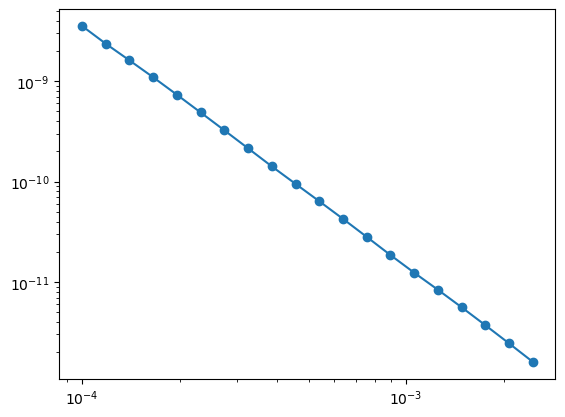

In [15]:
key = "background"
src = data_dict_invert[key].survey.source_list[0]
rx = src.receiver_list[0]
plt.loglog(rx_times[:n_times_invert], -data_dict_invert[key][src, rx], "-o")

In [16]:
rx_times[n_times_invert]

np.float64(0.0029101499992409746)

In [33]:
refine_depth = 120 # refine our local mesh to 200m 

def get_local_mesh(src):
    mesh_local = discretize.TreeMesh(mesh.h, origin=mesh.origin, diagonal_balance=True)
    refine_points = discretize.utils.ndgrid(
        np.r_[src.location[0]],
        np.r_[src.location[1]],
        np.linspace(-refine_depth, src.location[2], 40)
    )
    mesh_local.refine_points(
        refine_points,
        level=-1,
        padding_cells_by_level=[1, 4, 6, 2],
        finalize=True,
        diagonal_balance=True
    )
    return mesh_local

with ProcessPoolExecutor() as executor:
    mesh_list = list(executor.map(get_local_mesh, source_list))

In [34]:
mesh_list[0]

OcTreeMesh,0.00% filled
Level,Number of cells
2,16
3,336
4,320
5,388
6,722
7,1538
8,4772
9,1596
10,288


In [35]:
with open(f"synthetic-data-10m/true-models.pkl", "rb") as f:
    true_models = pickle.load(f)

In [36]:
len(true_models["target_15"])

120576

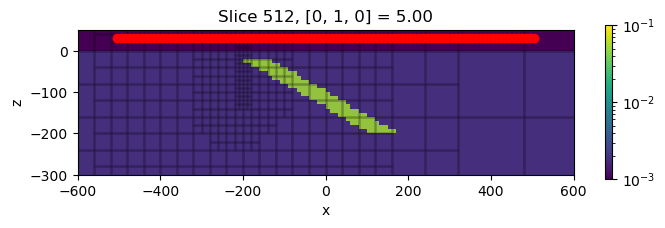

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

mesh_local = mesh_list[30]

plt.colorbar(
    mesh.plot_slice(
        true_models["target_30"], 
        # grid=True, 
        normal="y",
        pcolor_opts={"norm":LogNorm(1e-3, 1e-1)},
        ax=ax)[0], 
    ax=ax
)
mesh_local.plot_slice(
    np.ones(mesh_local.n_cells), 
    # grid=True, 
    normal="y",
    grid_opts={"color":"k", "lw":1},
    pcolor_opts={"alpha":0.1},
    ax=ax
)
ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(np.r_[-300, 50])

ax.plot(rx_locs[:, 0], rx_locs[:, 2], "ro")
ax.set_aspect(1)


In [38]:
time_steps = [
    (1e-6, 30), 
    (3e-6, 30), 
    (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
]

np.sum(discretize.utils.unpack_widths(time_steps))

np.float64(0.0030199999999999997)

In [39]:
mappings = []
sims = []

for ii, local_mesh in enumerate(mesh_list):
    
    tile_map = maps.TileMap(mesh, active_cells_map.active_cells, local_mesh)
    mappings.append(tile_map)
    
    local_actmap = maps.InjectActiveCells(
        local_mesh, 
        active_cells=tile_map.local_active, 
        value_inactive=np.log(1e-8)
    )
    
    local_survey = tdem.Survey([survey.source_list[ii]])
    sims.append(tdem.simulation.Simulation3DElectricField(
            mesh=local_mesh,
            survey=local_survey,
            time_steps=time_steps,
            solver=Solver,
            sigmaMap=maps.ExpMap() * local_actmap
        )
    )



In [40]:
len(sims)

102

In [41]:
inds = slice(47, 53)
len(sims[inds])

6

In [42]:
# downsample = 20
sim = MultiprocessingMetaSimulation(sims[inds], mappings[inds])


/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(grid[..., 1]),
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/geoana/spatial.py:104: RuntimeWarning: invalid value encountered in multiply
  vec[..., 0] * np.cos(grid[..., 1]) - vec[..., 1] * np.sin(gr

In [43]:
with open(f"{directory}/true-models.pkl", "rb") as f:
    true_models = pickle.load(f)

In [44]:
true_models.keys()

dict_keys(['background', 'target_0', 'target_15', 'target_30', 'target_45'])

In [45]:
# %%time
# tmp = sim.dpred(np.log(1/500) * np.ones(np.sum(active_cells_map.active_cells)))

In [46]:
downsampled_data_dict = {}

for key, val in data_dict_invert.items(): 
    source_list_downsampled = val.survey.source_list[inds]
    survey_downsampled = tdem.Survey(source_list_downsampled)
    downsampled_data_dict[key] = Data(
        survey=survey_downsampled, 
        dobs=np.hstack(
            [val[src, src.receiver_list[0]] for src in source_list_downsampled]
        ),
        noise_floor=1e-11, 
        relative_error=0.1
    )

In [47]:
%%time
key = "target_0"
fwd_target = sim.dpred(np.log(true_models[key])[active_cells_map.active_cells])

CPU times: user 23.2 ms, sys: 26.1 ms, total: 49.3 ms
Wall time: 1min 1s


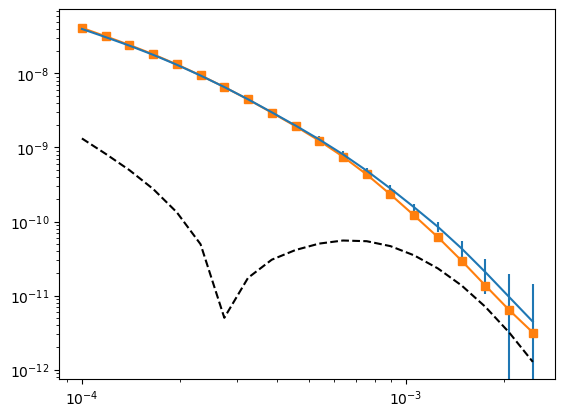

In [48]:
fig, ax = plt.subplots(1, 1)

# key = "target_0"
ind = 0
src = downsampled_data_dict[key].survey.source_list[ind]
rx = src.receiver_list[0]
ax.errorbar(rx_times[:n_times_invert], -downsampled_data_dict[key][src, rx], yerr=downsampled_data_dict[key].standard_deviation[n_times_invert*ind:n_times_invert*(ind+1)])

ax.loglog(rx_times[:n_times_invert], -fwd_target[n_times_invert*ind:n_times_invert*(ind+1)], "-s")

ax.loglog(rx_times[:n_times_invert], np.abs(downsampled_data_dict[key][src, rx]-fwd_target[n_times_invert*ind:n_times_invert*(ind+1)]), "--k")

(-500.0, 10.0)

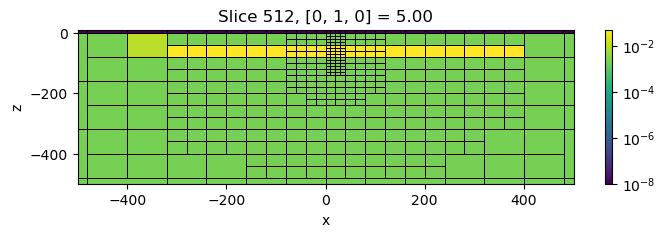

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2)) 

ind = 5
mesh_local = sim.simulations[ind].mesh

plt.colorbar(mesh_local.plot_slice(
    (
        sim.simulations[ind].sigmaMap @ 
        sim.mappings[ind] @ 
        np.log(true_models["target_0"])[active_cells_map.active_cells])
    , 
    # grid=True, 
    normal="y",
    grid_opts={"color":"k", "lw":0.5},
    pcolor_opts={"norm":LogNorm()},
    ax=ax
)[0], ax=ax)
ax.set_xlim(500*np.r_[-1, 1])
ax.set_ylim(np.r_[-500, 10])

In [50]:
# set up 1D inversion 
def create_inversion(data_invert): 
    # relative_error=0.1
    # noise_floor=1e-11
    # alpha_s = 1e-1
    # alpha_x = 1
    rho_back = 500
    # beta0 = 10
    
    
    dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_invert)
    reg = regularization.WeightedLeastSquares(
        mesh, 
        active_cells=active_cells_map.active_cells,
        # alpha_s=1e-6, 
        # alpha_x=alpha_x, 
        # reference_model=np.log(1./rho_back),
        # norms=norms
    )
    
    opt = optimization.InexactGaussNewton(maxIter=10, maxIterCG=30, tolCG=1e-3)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    
    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
    
    cool_beta = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
    
    # Update the preconditionner
    # update_Jacobi = directives.UpdatePreconditioner()
    
    # Options for outputting recovered models and predicted data for each beta.
    save_iteration = directives.SaveOutputDictEveryIteration(
        saveOnDisk=False, name=f"inv-dict-{rx.locations[0,0]}"
    )
    
    
    # Updating the preconditionner if it is model dependent.
    # update_jacobi = directives.UpdatePreconditioner()
    
    # Add sensitivity weights
    # sensitivity_weights = directives.UpdateSensitivityWeights()
    
    target_misfit = directives.TargetMisfit()
    
    # The directives are defined as a list.
    directives_list = [
        # sensitivity_weights,
        # update_jacobi,
        starting_beta,
        cool_beta,
        save_iteration,
        target_misfit,
    ]
    
    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)
    return inv

In [51]:
inv_directory = "/t40array/lheagy/2025-heagy-et-al-tle/synthetic-invs-3d"

In [52]:
rho_start = 500
m0 = np.log(1/rho_start) * np.ones(np.sum(active_cells_map.active_cells))


In [53]:
1./np.exp(np.unique(m0))

array([500.])

In [54]:
def run_inv(key): 
    inv = create_inversion(downsampled_data_dict[key])
    rho_start = 500
    m0 = np.log(1/rho_start) * np.ones(np.sum(active_cells_map.active_cells))
    
    mopt = inv.run(m0)
    # np.save(f"{inv_directory}/{key}_model.npy", mopt)
    
    # inv_dict = inv.directiveList.dList[-2].outDict
    # with open(f"{inv_directory}/{key}_inv_dict.pkl", "wb") as f:
    #     pickle.dump(inv_dict, f)

    return mopt, inv


In [55]:
tmp = downsampled_data_dict[key]

In [56]:
src_x = np.hstack([s.location[0] for s in downsampled_data_dict[key].survey.source_list])

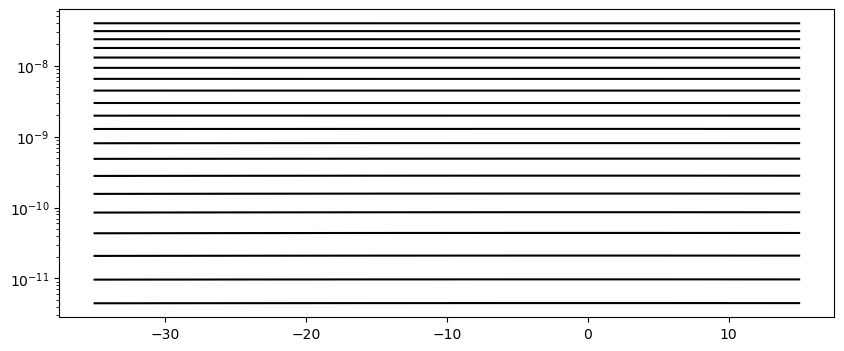

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.semilogy(src_x, -tmp.dobs.reshape(len(src_x), n_times_invert), color="k");


In [58]:
# inv_dict.invProb.dmisfit(np.log(true_models["background"][active_cells_map.active_cells]))

In [59]:
%%time
if __name__ == "__main__": 
    mopt, inv = run_inv("target_0")


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.34e-11  8.01e+03  0.00e+00  

In [60]:
mopt

array([-6.21460814, -6.21460823, -6.21460823, ..., -6.2145753 ,
       -6.21457529, -6.21460708])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

plt.colorbar(mesh.plot_slice(
    np.exp(active_cells_map * mopt), 
    pcolor_opts={"norm":LogNorm()},
    ax=ax,
    ind=512,
    normal="Y"
)[0])

ax.set_xlim(600*np.r_[-1, 1])
ax.set_ylim(-200, 10)
ax.set_aspect(1)

In [47]:
inv_outputs = inv_dict.directiveList.dList[-2].outDict

array([-6.2146081 , -6.21460809, -6.21460809, ..., -6.21460833,
       -6.21460833, -6.21460711])

In [ ]:
# mopt_dict = {}
# inv_dict = {}

# for key in list(downsampled_data_dict.keys())[1:]:
#     mopt_dict[key], inv_dict[key] = run_inv(key)
    


Running inversion with SimPEG v0.24.0
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                    simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    


In [ ]:
5

In [ ]:
mopt_dict[""]

In [ ]:
mopt_dict.keys()

In [34]:
# key = "target_0"
# n_times_invert = 20
# ind = 0
# src = full_survey.source_list[ind]
# rx = src.receiver_list[0]
# dobs = data_dict[key][src, rx][:n_times_invert]

# inv = create_inversion(key, ind, dobs)

In [35]:
    # rho_start = 500
    # m0 = np.log(1/rho_start) * np.ones(len(thicknesses1d)+1)
    # mopt = inv.run(m0)
    


In [36]:
# iterations = len(inv.directiveList.dList[-2].outDict)

In [37]:

# # plt.loglog(rx_times, -data_dict["background"][src, src.receiver_list[0]], "k", alpha=0.5)
# # plt.loglog(rx_times, -data_dict[key][src, rx], "C0o", ms=4)
# rx_times_invert = rx_times[:n_times_invert]
# plt.errorbar(rx_times_invert, -inv.invProb.dmisfit[0][1].data.dobs, yerr=inv.invProb.dmisfit[0][1].data.standard_deviation)
# plt.loglog(rx_times_invert, -inv.directiveList.dList[-2].outDict[iterations]["dpred"], "C1-s", ms=4)

In [38]:

# rho_back = 500
# sigma_back = 1./rho_back 

# rho_target = 20
# sigma_target = 1./rho_target
# target_z_center = -60
# target_thickness = 40

# model_true = np.log(1/np.r_[rho_back, rho_target, rho_back])

# thicknesses_true = np.r_[-target_z_center - target_thickness/2, target_thickness]

In [39]:
# fig, ax = plt.subplots(1, 1, figsize=(2, 4))
# plot_1d_layer_model(
#     thicknesses1d, np.exp(mopt), ax=ax, color="C0", label="recovered"
# )
# plot_1d_layer_model(
#     thicknesses_true, np.exp(model_true), ax=ax, color="k", label="true"
# )
# ax.set_ylim([250, 0])
# ax.set_xlim([1e-4, 1e-1])
